In [1]:
# Install PyTorch
!pip install -U torch==1.8.1+cu101 torchvision==0.9.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# Install MMCV
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html


In [2]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 5683, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 5683 (delta 77), reused 87 (delta 43), pack-reused 5493
Receiving objects: 100% (5683/5683), 12.00 MiB | 38.89 MiB/s, done.
Resolving deltas: 100% (4143/4143), done.
/content/mmsegmentation
Obtaining file:///content/mmsegmentation
  Running setup.py develop for mmsegmentation


In [3]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
from mmseg.datasets import build_dataset
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
from mmseg.apis import set_random_seed, train_segmentor
from mmseg.models import build_segmentor
print(mmseg.__version__)

import mmcv
from mmcv import Config

import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

1.8.1+cu101 True
0.20.2


In [4]:
!rm -rf segmentation/
!unzip ../segmentationV4-1.zip
!mv segmentationV4/segmentation segmentation

Archive:  ../segmentationV4-1.zip
   creating: segmentationV4/segmentation/
   creating: segmentationV4/segmentation/annotations/
  inflating: segmentationV4/segmentation/annotations/image020-roi1.tif  
  inflating: segmentationV4/segmentation/annotations/image008-roi1.tif  
  inflating: segmentationV4/segmentation/annotations/image032-roi1.tif  
  inflating: segmentationV4/segmentation/annotations/image019-roi2.tif  
  inflating: segmentationV4/segmentation/annotations/image019-roi5.tif  
  inflating: segmentationV4/segmentation/annotations/image058-roi5.tif  
  inflating: segmentationV4/segmentation/annotations/image038-roi4.tif  
  inflating: segmentationV4/segmentation/annotations/image058-roi1.tif  
  inflating: segmentationV4/segmentation/annotations/image021-roi3.tif  
  inflating: segmentationV4/segmentation/annotations/image006-roi2.tif  
  inflating: segmentationV4/segmentation/annotations/image021-roi6.tif  
  inflating: segmentationV4/segmentation/annotations/image038-roi1.

In [5]:
data_root = 'segmentation'
img_dir = 'images'
ann_dir = 'annotations'

In [6]:
classes = ('bg', 'cell')
palette = [[0, 0, 0], [255, 255, 255]]

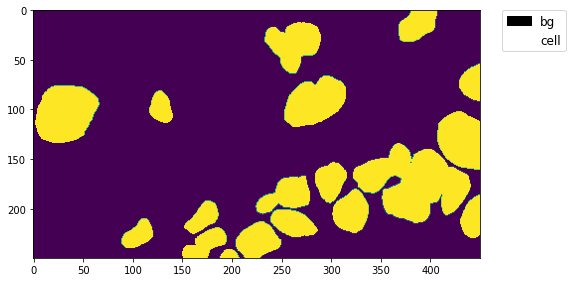

In [7]:
# Let's take a look at the segmentation map we got

img = Image.open('segmentation/annotations/image003-2-roi1.tif')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [8]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.tif')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
    # select first 4/5 as train set
    train_length = int(len(filename_list)*4/5)
    f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
    # select last 1/5 as train set
    f.writelines(line + '\n' for line in filename_list[train_length:])

In [9]:
@DATASETS.register_module()
class TestDataSetResize(CustomDataset):
    CLASSES = classes
    PALETTE = palette
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.jpg', seg_map_suffix='.tif', split=split, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None

In [10]:
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

In [11]:
# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

# Modify dataset type and path
cfg.dataset_type = 'TestDataSetResize'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 4

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 2000
cfg.log_config.interval = 100
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=F

In [12]:
datasets = [build_dataset(cfg.data.train)]

2022-01-19 23:46:47,719 - mmseg - INFO - Loaded 96 images


In [13]:
# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '


In [14]:
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
2022-01-19 23:46:51,793 - mmseg - INFO - Loaded 24 images
2022-01-19 23:46:51,794 - mmseg - INFO - Start running, host: root@3583bfee0684, work_dir: /content/mmsegmentation/work_dirs/tutorial
2022-01-19 23:46:51,795 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 19.6 task/s, elapsed: 1s, ETA:     0s

2022-01-19 23:49:24,098 - mmseg - INFO - per class results:
2022-01-19 23:49:24,099 - mmseg - INFO - 
+-------+-------+-------+
| Class |  IoU  |  Acc  |
+-------+-------+-------+
|   bg  | 72.52 | 84.81 |
|  cell | 49.47 |  65.0 |
+-------+-------+-------+
2022-01-19 23:49:24,101 - mmseg - INFO - Summary:
2022-01-19 23:49:24,102 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 78.34 | 60.99 | 74.9 |
+-------+-------+------+
2022-01-19 23:49:24,105 - mmseg - INFO - Iter(val) [24]	aAcc: 0.7834, mIoU: 0.6099, mAcc: 0.7490, IoU.bg: 0.7252, IoU.cell: 0.4947, Acc.bg: 0.8481, Acc.cell: 0.6500
2022-01-19 23:50:38,999 - mmseg - INFO - Iter [300/2000]	lr: 8.657e-03, eta: 0:21:26, time: 0.761, data_time: 0.194, memory: 3768, decode.loss_ce: 0.3335, decode.acc_seg: 62.6464, aux.loss_ce: 0.1364, aux.acc_seg: 62.2676, loss: 0.4699
2022-01-19 23:51:56,137 - mmseg - INFO - Saving checkpoint at 400 iterations
2022-01-19 23:51:59,030 - mmseg - INFO - Iter [

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 23.0 task/s, elapsed: 1s, ETA:     0s

2022-01-19 23:52:00,087 - mmseg - INFO - per class results:
2022-01-19 23:52:00,090 - mmseg - INFO - 
+-------+-------+-------+
| Class |  IoU  |  Acc  |
+-------+-------+-------+
|   bg  | 74.88 | 89.12 |
|  cell | 49.58 | 60.72 |
+-------+-------+-------+
2022-01-19 23:52:00,090 - mmseg - INFO - Summary:
2022-01-19 23:52:00,097 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.86 | 62.23 | 74.92 |
+-------+-------+-------+
2022-01-19 23:52:00,098 - mmseg - INFO - Iter(val) [24]	aAcc: 0.7986, mIoU: 0.6223, mAcc: 0.7492, IoU.bg: 0.7488, IoU.cell: 0.4958, Acc.bg: 0.8912, Acc.cell: 0.6072
2022-01-19 23:53:14,987 - mmseg - INFO - Iter [500/2000]	lr: 7.746e-03, eta: 0:19:08, time: 0.759, data_time: 0.192, memory: 3768, decode.loss_ce: 0.3107, decode.acc_seg: 63.2907, aux.loss_ce: 0.1272, aux.acc_seg: 62.9201, loss: 0.4378
2022-01-19 23:54:29,956 - mmseg - INFO - Saving checkpoint at 600 iterations
2022-01-19 23:54:31,949 - mmseg - INFO - I

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 23.3 task/s, elapsed: 1s, ETA:     0s

2022-01-19 23:54:32,987 - mmseg - INFO - per class results:
2022-01-19 23:54:32,989 - mmseg - INFO - 
+-------+-------+-------+
| Class |  IoU  |  Acc  |
+-------+-------+-------+
|   bg  | 69.24 | 75.46 |
|  cell | 54.04 | 81.44 |
+-------+-------+-------+
2022-01-19 23:54:32,991 - mmseg - INFO - Summary:
2022-01-19 23:54:32,998 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.41 | 61.64 | 78.45 |
+-------+-------+-------+
2022-01-19 23:54:33,000 - mmseg - INFO - Iter(val) [24]	aAcc: 0.7741, mIoU: 0.6164, mAcc: 0.7845, IoU.bg: 0.6924, IoU.cell: 0.5404, Acc.bg: 0.7546, Acc.cell: 0.8144
2022-01-19 23:55:50,258 - mmseg - INFO - Iter [700/2000]	lr: 6.823e-03, eta: 0:16:39, time: 0.783, data_time: 0.213, memory: 3768, decode.loss_ce: 0.2867, decode.acc_seg: 64.9332, aux.loss_ce: 0.1180, aux.acc_seg: 64.5289, loss: 0.4047
2022-01-19 23:57:05,113 - mmseg - INFO - Saving checkpoint at 800 iterations
2022-01-19 23:57:06,779 - mmseg - INFO - I

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 26.1 task/s, elapsed: 1s, ETA:     0s

2022-01-19 23:57:07,716 - mmseg - INFO - per class results:
2022-01-19 23:57:07,718 - mmseg - INFO - 
+-------+-------+-------+
| Class |  IoU  |  Acc  |
+-------+-------+-------+
|   bg  | 72.56 | 79.73 |
|  cell | 56.09 | 79.58 |
+-------+-------+-------+
2022-01-19 23:57:07,718 - mmseg - INFO - Summary:
2022-01-19 23:57:07,721 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.68 | 64.32 | 79.65 |
+-------+-------+-------+
2022-01-19 23:57:07,726 - mmseg - INFO - Iter(val) [24]	aAcc: 0.7968, mIoU: 0.6432, mAcc: 0.7965, IoU.bg: 0.7256, IoU.cell: 0.5609, Acc.bg: 0.7973, Acc.cell: 0.7958
2022-01-19 23:58:22,715 - mmseg - INFO - Iter [900/2000]	lr: 5.885e-03, eta: 0:14:04, time: 0.759, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2804, decode.acc_seg: 66.5098, aux.loss_ce: 0.1166, aux.acc_seg: 65.9726, loss: 0.3970
2022-01-19 23:59:39,946 - mmseg - INFO - Saving checkpoint at 1000 iterations
2022-01-19 23:59:42,117 - mmseg - INFO - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 24.5 task/s, elapsed: 1s, ETA:     0s

2022-01-19 23:59:43,109 - mmseg - INFO - per class results:
2022-01-19 23:59:43,110 - mmseg - INFO - 
+-------+-------+-------+
| Class |  IoU  |  Acc  |
+-------+-------+-------+
|   bg  | 75.76 | 87.34 |
|  cell | 54.25 | 68.43 |
+-------+-------+-------+
2022-01-19 23:59:43,112 - mmseg - INFO - Summary:
2022-01-19 23:59:43,114 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.17 | 65.01 | 77.89 |
+-------+-------+-------+
2022-01-19 23:59:43,117 - mmseg - INFO - Iter(val) [24]	aAcc: 0.8117, mIoU: 0.6501, mAcc: 0.7789, IoU.bg: 0.7576, IoU.cell: 0.5425, Acc.bg: 0.8734, Acc.cell: 0.6843
2022-01-20 00:00:58,021 - mmseg - INFO - Iter [1100/2000]	lr: 4.930e-03, eta: 0:11:32, time: 0.758, data_time: 0.190, memory: 3768, decode.loss_ce: 0.2677, decode.acc_seg: 66.6684, aux.loss_ce: 0.1114, aux.acc_seg: 66.1527, loss: 0.3790
2022-01-20 00:02:12,884 - mmseg - INFO - Saving checkpoint at 1200 iterations
2022-01-20 00:02:14,816 - mmseg - INFO -

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 23.5 task/s, elapsed: 1s, ETA:     0s

2022-01-20 00:02:15,854 - mmseg - INFO - per class results:
2022-01-20 00:02:15,856 - mmseg - INFO - 
+-------+-------+-------+
| Class |  IoU  |  Acc  |
+-------+-------+-------+
|   bg  | 75.84 | 86.16 |
|  cell | 55.92 | 71.91 |
+-------+-------+-------+
2022-01-20 00:02:15,857 - mmseg - INFO - Summary:
2022-01-20 00:02:15,861 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.51 | 65.88 | 79.03 |
+-------+-------+-------+
2022-01-20 00:02:15,867 - mmseg - INFO - Iter(val) [24]	aAcc: 0.8151, mIoU: 0.6588, mAcc: 0.7903, IoU.bg: 0.7584, IoU.cell: 0.5592, Acc.bg: 0.8616, Acc.cell: 0.7191
2022-01-20 00:03:33,237 - mmseg - INFO - Iter [1300/2000]	lr: 3.953e-03, eta: 0:08:59, time: 0.784, data_time: 0.214, memory: 3768, decode.loss_ce: 0.2587, decode.acc_seg: 66.6117, aux.loss_ce: 0.1083, aux.acc_seg: 66.0603, loss: 0.3671
2022-01-20 00:04:48,114 - mmseg - INFO - Saving checkpoint at 1400 iterations
2022-01-20 00:04:49,991 - mmseg - INFO -

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 22.8 task/s, elapsed: 1s, ETA:     0s

2022-01-20 00:04:51,050 - mmseg - INFO - per class results:
2022-01-20 00:04:51,054 - mmseg - INFO - 
+-------+-------+-------+
| Class |  IoU  |  Acc  |
+-------+-------+-------+
|   bg  | 72.05 | 78.15 |
|  cell | 56.84 | 82.51 |
+-------+-------+-------+
2022-01-20 00:04:51,057 - mmseg - INFO - Summary:
2022-01-20 00:04:51,062 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.57 | 64.44 | 80.33 |
+-------+-------+-------+
2022-01-20 00:04:51,065 - mmseg - INFO - Iter(val) [24]	aAcc: 0.7957, mIoU: 0.6444, mAcc: 0.8033, IoU.bg: 0.7205, IoU.cell: 0.5684, Acc.bg: 0.7815, Acc.cell: 0.8251
2022-01-20 00:06:06,090 - mmseg - INFO - Iter [1500/2000]	lr: 2.948e-03, eta: 0:06:24, time: 0.760, data_time: 0.191, memory: 3768, decode.loss_ce: 0.2488, decode.acc_seg: 66.3790, aux.loss_ce: 0.1047, aux.acc_seg: 65.7927, loss: 0.3535
2022-01-20 00:07:23,250 - mmseg - INFO - Saving checkpoint at 1600 iterations
2022-01-20 00:07:25,046 - mmseg - INFO -

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 25.2 task/s, elapsed: 1s, ETA:     0s

2022-01-20 00:07:26,007 - mmseg - INFO - per class results:
2022-01-20 00:07:26,009 - mmseg - INFO - 
+-------+-------+-------+
| Class |  IoU  |  Acc  |
+-------+-------+-------+
|   bg  | 74.71 |  82.2 |
|  cell | 57.96 | 79.27 |
+-------+-------+-------+
2022-01-20 00:07:26,011 - mmseg - INFO - Summary:
2022-01-20 00:07:26,013 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.25 | 66.33 | 80.74 |
+-------+-------+-------+
2022-01-20 00:07:26,021 - mmseg - INFO - Iter(val) [24]	aAcc: 0.8125, mIoU: 0.6633, mAcc: 0.8074, IoU.bg: 0.7471, IoU.cell: 0.5796, Acc.bg: 0.8220, Acc.cell: 0.7927
2022-01-20 00:08:41,025 - mmseg - INFO - Iter [1700/2000]	lr: 1.901e-03, eta: 0:03:50, time: 0.759, data_time: 0.190, memory: 3768, decode.loss_ce: 0.2474, decode.acc_seg: 66.8446, aux.loss_ce: 0.1044, aux.acc_seg: 66.2436, loss: 0.3518
2022-01-20 00:09:56,093 - mmseg - INFO - Saving checkpoint at 1800 iterations
2022-01-20 00:09:57,990 - mmseg - INFO -

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 23.3 task/s, elapsed: 1s, ETA:     0s

2022-01-20 00:09:59,030 - mmseg - INFO - per class results:
2022-01-20 00:09:59,032 - mmseg - INFO - 
+-------+-------+-------+
| Class |  IoU  |  Acc  |
+-------+-------+-------+
|   bg  | 76.26 | 85.34 |
|  cell | 57.87 | 75.39 |
+-------+-------+-------+
2022-01-20 00:09:59,034 - mmseg - INFO - Summary:
2022-01-20 00:09:59,038 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 82.1 | 67.06 | 80.37 |
+------+-------+-------+
2022-01-20 00:09:59,043 - mmseg - INFO - Iter(val) [24]	aAcc: 0.8210, mIoU: 0.6706, mAcc: 0.8037, IoU.bg: 0.7626, IoU.cell: 0.5787, Acc.bg: 0.8534, Acc.cell: 0.7539
2022-01-20 00:11:16,395 - mmseg - INFO - Iter [1900/2000]	lr: 7.739e-04, eta: 0:01:17, time: 0.783, data_time: 0.214, memory: 3768, decode.loss_ce: 0.2403, decode.acc_seg: 66.5108, aux.loss_ce: 0.1015, aux.acc_seg: 65.9118, loss: 0.3418
2022-01-20 00:12:31,404 - mmseg - INFO - Saving checkpoint at 2000 iterations
2022-01-20 00:12:33,754 - mmseg - INFO - Iter

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 22.6 task/s, elapsed: 1s, ETA:     0s

2022-01-20 00:12:34,829 - mmseg - INFO - per class results:
2022-01-20 00:12:34,831 - mmseg - INFO - 
+-------+-------+-------+
| Class |  IoU  |  Acc  |
+-------+-------+-------+
|   bg  | 75.46 | 83.71 |
|  cell | 57.93 | 77.42 |
+-------+-------+-------+
2022-01-20 00:12:34,832 - mmseg - INFO - Summary:
2022-01-20 00:12:34,835 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.66 | 66.69 | 80.56 |
+-------+-------+-------+
2022-01-20 00:12:34,838 - mmseg - INFO - Iter(val) [24]	aAcc: 0.8166, mIoU: 0.6669, mAcc: 0.8056, IoU.bg: 0.7546, IoU.cell: 0.5793, Acc.bg: 0.8371, Acc.cell: 0.7742


/content/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

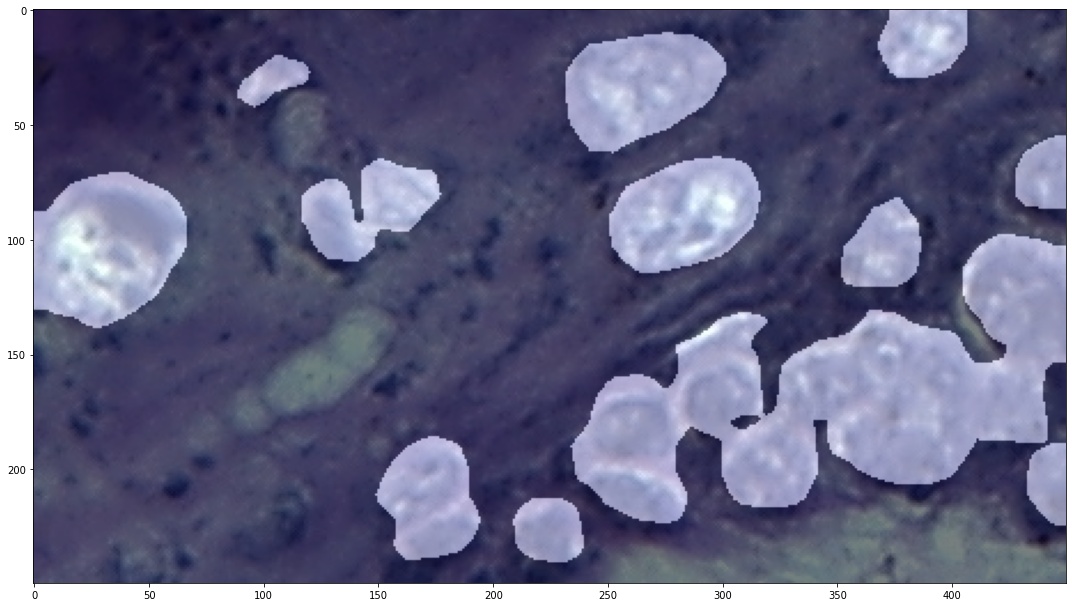

In [15]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('/content/mmsegmentation/segmentation/images/image003-2-roi1.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

/content/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

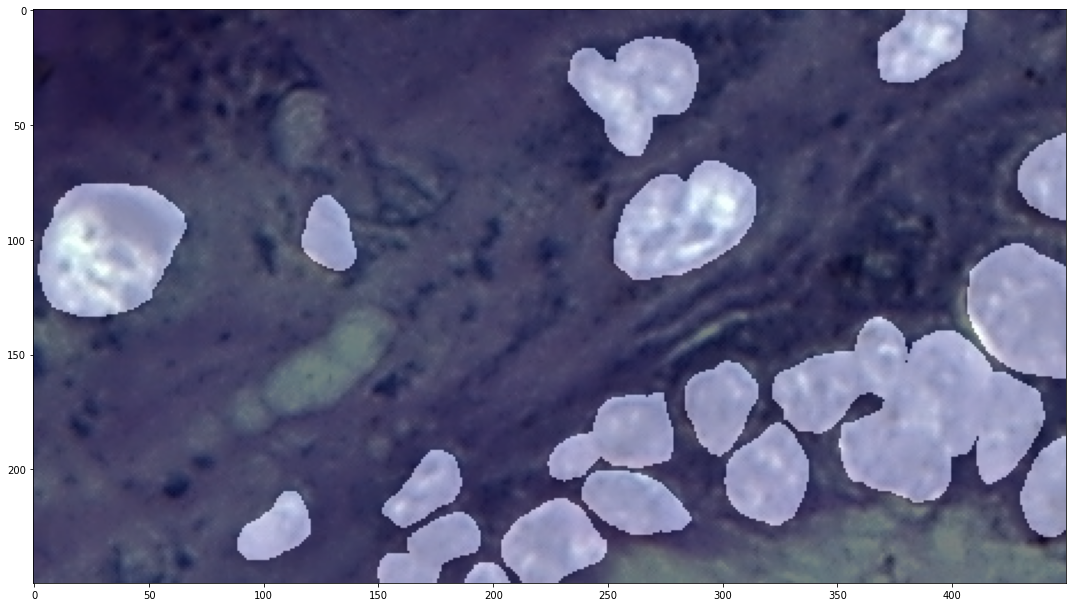

In [23]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('/content/mmsegmentation/segmentation/images/image003-2-roi1.jpg')
result = mmcv.imread('/content/mmsegmentation/segmentation/annotations/image003-2-roi1.tif',flag='grayscale')

model.cfg = cfg
# result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, [result], palette)

/content/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

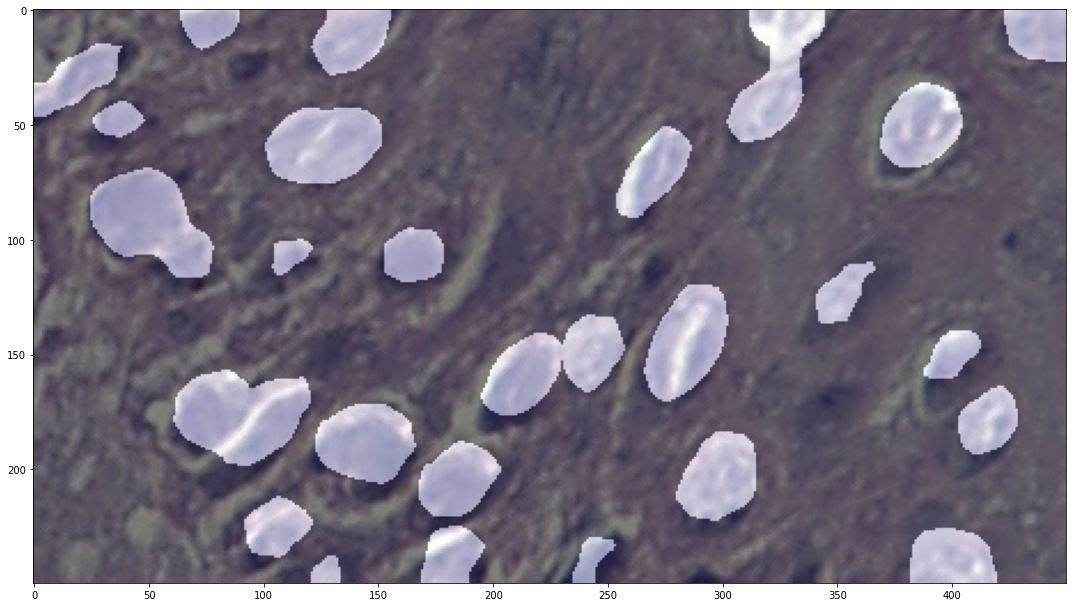

In [20]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('/content/mmsegmentation/segmentation/images/image037-roi4.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

/content/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

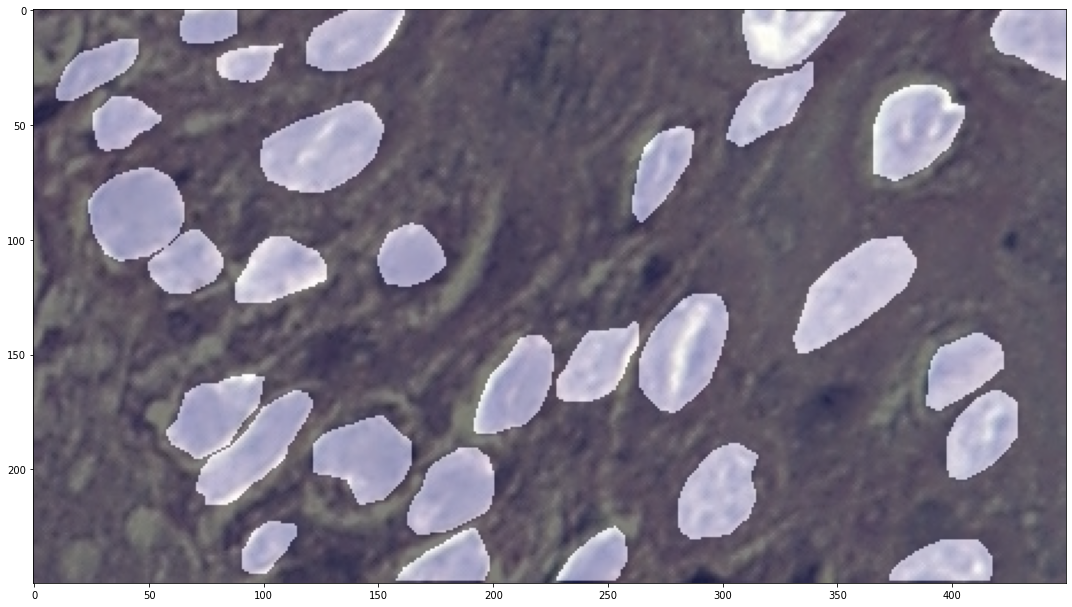

In [24]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('/content/mmsegmentation/segmentation/images/image037-roi4.jpg')
result = mmcv.imread('/content/mmsegmentation/segmentation/annotations/image037-roi4.tif',flag='grayscale')

model.cfg = cfg
# result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, [result], palette)